In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from einops import rearrange
from functools import partial
from lpdm.data import field_preprocess, get_well_dataset, isotropic_power_spectrum
from lpdm.nn.autoencoder import AutoEncoder
from omegaconf import OmegaConf
from pathlib import Path

In [2]:
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/dryair_64x64_small_083a5e652e9041179141ad7b512b3d90")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
device = "cuda"

## Data

In [3]:
testset = get_well_dataset(
    path=f"/mnt/ceph/users/polymathic/the_well/datasets/{cfg.dataset.physics}/data/test",
    in_steps=True,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [4]:
model = AutoEncoder(
    pix_channels=len(cfg.dataset.fields),
    lat_channels=cfg.ae.lat_channels,
    hid_channels=cfg.ae.hid_channels,
    hid_blocks=cfg.ae.hid_blocks,
    spatial=2,
)

model.load_state_dict(torch.load(runpath / "state.pth"))
model.cuda()
model.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1-3): 3 x ResBlock(
          (block): Sequential(
            (0): LayerNorm(dim=1)
            (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): LayerNorm(dim=1)
        )
        (1-3): 3 x ResBlock(
          (block): Sequential(
            (0): LayerNorm(dim=1)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )


## Evaluation

In [5]:
x = testset[69]
x = x["input_fields"]
x = preprocess(x)
x = rearrange(x, "T H W C -> T C H W")
x = x.cuda()

with torch.no_grad():
    z = model.encode(x)
    y = model.decode(z)

x = x.detach().cpu().squeeze(0)
y = y.detach().cpu().squeeze(0)

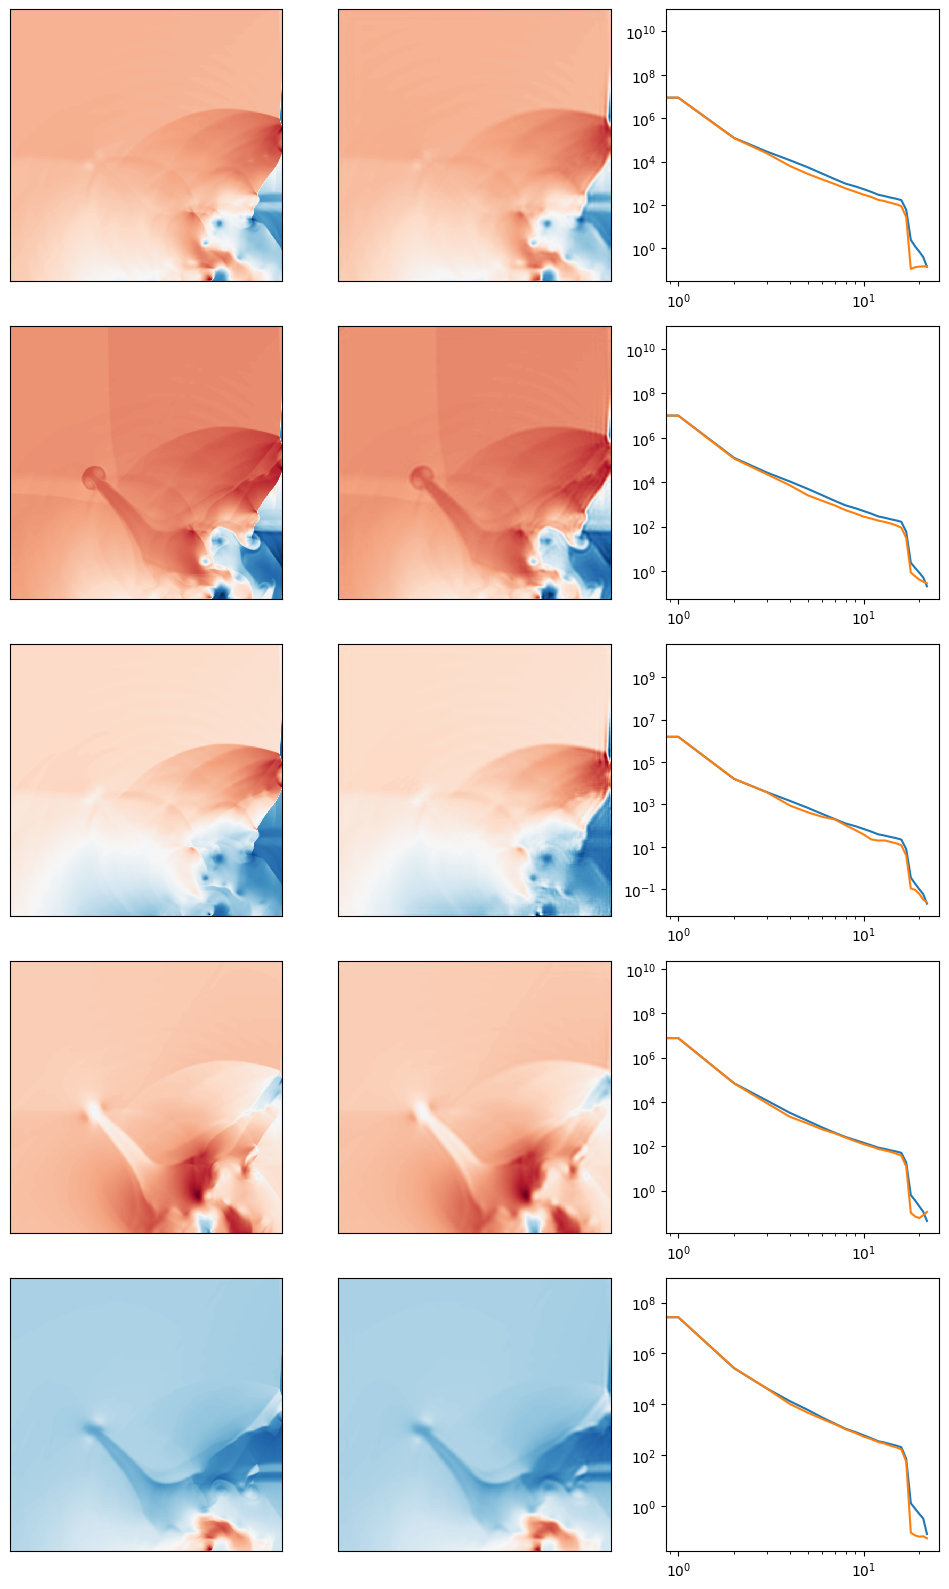

In [6]:
fig, axs = plt.subplots(5, 3, figsize=(9.6, 16.0))

for field in range(5):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[field, 0].imshow(x[field], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
    axs[field, 0].set_xticks([])
    axs[field, 0].set_yticks([])

    axs[field, 1].imshow(y[field], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax)
    axs[field, 1].set_xticks([])
    axs[field, 1].set_yticks([])

    x_ps, _ = isotropic_power_spectrum(x[field], spatial=2)
    y_ps, _ = isotropic_power_spectrum(y[field], spatial=2)

    axs[field, 2].loglog(x_ps)
    axs[field, 2].loglog(y_ps)

plt.tight_layout()